## What's this TensorFlow business?

You've written a lot of code in this assignment to provide a whole host of neural network functionality. Dropout, Batch Norm, and 2D convolutions are some of the workhorses of deep learning in computer vision. You've also worked hard to make your code efficient and vectorized.

For the last part of this assignment, though, we're going to leave behind your beautiful codebase and instead migrate to one of two popular deep learning frameworks: in this instance, TensorFlow (or PyTorch, if you switch over to that notebook)

#### What is it?
TensorFlow is a system for executing computational graphs over Tensor objects, with native support for performing backpropogation for its Variables. In it, we work with Tensors which are n-dimensional arrays analogous to the numpy ndarray.

#### Why?

* Our code will now run on GPUs! Much faster training. Writing your own modules to run on GPUs is beyond the scope of this class, unfortunately.
* We want you to be ready to use one of these frameworks for your project so you can experiment more efficiently than if you were writing every feature you want to use by hand. 
* We want you to stand on the shoulders of giants! TensorFlow and PyTorch are both excellent frameworks that will make your lives a lot easier, and now that you understand their guts, you are free to use them :) 
* We want you to be exposed to the sort of deep learning code you might run into in academia or industry. 

## How will I learn TensorFlow?

TensorFlow has many excellent tutorials available, including those from [Google themselves](https://www.tensorflow.org/get_started/get_started).

Otherwise, this notebook will walk you through much of what you need to do to train models in TensorFlow. See the end of the notebook for some links to helpful tutorials if you want to learn more or need further clarification on topics that aren't fully explained here.

## Load Datasets


In [1]:
import tensorflow as tf
import numpy as np
import math
import timeit
import matplotlib.pyplot as plt
%matplotlib inline

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from cs231n.data_utils import load_CIFAR10

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=10000):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the two-layer neural net classifier. These are the same steps as
    we used for the SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

    # Subsample the data
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image

    return X_train, y_train, X_val, y_val, X_test, y_test


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


## Example Model

### Some useful utilities

. Remember that our image data is initially N x H x W x C, where:
* N is the number of datapoints
* H is the height of each image in pixels
* W is the height of each image in pixels
* C is the number of channels (usually 3: R, G, B)

This is the right way to represent the data when we are doing something like a 2D convolution, which needs spatial understanding of where the pixels are relative to each other. When we input image data into fully connected affine layers, however, we want each data example to be represented by a single vector -- it's no longer useful to segregate the different channels, rows, and columns of the data.

### The example model itself

The first step to training your own model is defining its architecture.

Here's an example of a convolutional neural network defined in TensorFlow -- try to understand what each line is doing, remembering that each layer is composed upon the previous layer. We haven't trained anything yet - that'll come next - for now, we want you to understand how everything gets set up. 

In that example, you see 2D convolutional layers (Conv2d), ReLU activations, and fully-connected layers (Linear). You also see the Hinge loss function, and the Adam optimizer being used. 

Make sure you understand why the parameters of the Linear layer are 5408 and 10.

### TensorFlow Details
In TensorFlow, much like in our previous notebooks, we'll first specifically initialize our variables, and then our network model.

In [23]:
# clear old variables
tf.reset_default_graph()

# setup input (e.g. the data that changes every batch)
# The first dim is None, and gets sets automatically based on batch size fed in
X = tf.placeholder(tf.float32, [None, 32, 32, 3])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

def simple_model(X,y):
    # define our weights (e.g. init_two_layer_convnet)
    
    # setup variables
    Wconv1 = tf.get_variable("Wconv1", shape=[7, 7, 3, 32])
    bconv1 = tf.get_variable("bconv1", shape=[32])
    W1 = tf.get_variable("W1", shape=[5408, 10])
    b1 = tf.get_variable("b1", shape=[10])

    # define our graph (e.g. two_layer_convnet)
    a1 = tf.nn.conv2d(X, Wconv1, strides=[1,2,2,1], padding='VALID') + bconv1
    h1 = tf.nn.relu(a1)
    h1_flat = tf.reshape(h1,[-1,5408])
    y_out = tf.matmul(h1_flat,W1) + b1
    return y_out

y_out = simple_model(X,y)

# define our loss
total_loss = tf.losses.hinge_loss(tf.one_hot(y,10),logits=y_out)
mean_loss = tf.reduce_mean(total_loss)

# define our optimizer
optimizer = tf.train.AdamOptimizer(5e-4) # select optimizer and set learning rate
train_step = optimizer.minimize(mean_loss)



TensorFlow supports many other layer types, loss functions, and optimizers - you will experiment with these next. Here's the official API documentation for these (if any of the parameters used above were unclear, this resource will also be helpful). 

* Layers, Activations, Loss functions : https://www.tensorflow.org/api_guides/python/nn
* Optimizers: https://www.tensorflow.org/api_guides/python/train#Optimizers
* BatchNorm: https://www.tensorflow.org/api_docs/python/tf/layers/batch_normalization

### Training the model on one epoch
While we have defined a graph of operations above, in order to execute TensorFlow Graphs, by feeding them input data and computing the results, we first need to create a `tf.Session` object. A session encapsulates the control and state of the TensorFlow runtime. For more information, see the TensorFlow [Getting started](https://www.tensorflow.org/get_started/get_started) guide.

Optionally we can also specify a device context such as `/cpu:0` or `/gpu:0`. For documentation on this behavior see [this TensorFlow guide](https://www.tensorflow.org/tutorials/using_gpu)

You should see a validation loss of around 0.4 to 0.6 and an accuracy of 0.30 to 0.35 below

Training
Iteration 0: with minibatch training loss = 10.3 and accuracy of 0.094
Iteration 100: with minibatch training loss = 1.07 and accuracy of 0.23
Iteration 200: with minibatch training loss = 0.754 and accuracy of 0.38
Iteration 300: with minibatch training loss = 0.68 and accuracy of 0.33
Iteration 400: with minibatch training loss = 0.568 and accuracy of 0.34
Iteration 500: with minibatch training loss = 0.644 and accuracy of 0.23
Iteration 600: with minibatch training loss = 0.436 and accuracy of 0.38
Iteration 700: with minibatch training loss = 0.478 and accuracy of 0.36
Epoch 1, Overall loss = 0.764 and accuracy of 0.307


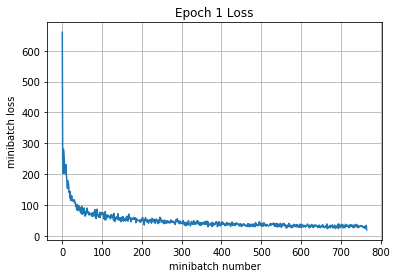

Validation
Epoch 1, Overall loss = 0.471 and accuracy of 0.378


In [24]:
def run_model(session, predict, loss_val, Xd, yd,
              epochs=1, batch_size=64, print_every=100,
              training=None, plot_losses=False):
    # have tensorflow compute accuracy
    correct_prediction = tf.equal(tf.argmax(predict,1), y)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    # shuffle indicies
    train_indicies = np.arange(Xd.shape[0])
    np.random.shuffle(train_indicies)

    training_now = training is not None
    
    # setting up variables we want to compute (and optimizing)
    # if we have a training function, add that to things we compute
    variables = [mean_loss,correct_prediction,accuracy]
    if training_now:
        variables[-1] = training
    
    # counter 
    iter_cnt = 0
    for e in range(epochs):
        # keep track of losses and accuracy
        correct = 0
        losses = []
        # make sure we iterate over the dataset once
        for i in range(int(math.ceil(Xd.shape[0]/batch_size))):
            # generate indicies for the batch
            start_idx = (i*batch_size)%Xd.shape[0]
            idx = train_indicies[start_idx:start_idx+batch_size]
            
            # create a feed dictionary for this batch
            feed_dict = {X: Xd[idx,:],
                         y: yd[idx],
                         is_training: training_now }
            # get batch size
            actual_batch_size = yd[idx].shape[0]
            
            # have tensorflow compute loss and correct predictions
            # and (if given) perform a training step
            loss, corr, _ = session.run(variables,feed_dict=feed_dict)
            
            # aggregate performance stats
            losses.append(loss*actual_batch_size)
            correct += np.sum(corr)
            
            # print every now and then
#             if loss > 500: 
#                 return 
            if training_now and (iter_cnt % print_every) == 0:
                print("Iteration {0}: with minibatch training loss = {1:.3g} and accuracy of {2:.2g}"\
                      .format(iter_cnt,loss,np.sum(corr)/actual_batch_size))
            iter_cnt += 1
        total_correct = correct/Xd.shape[0]
        total_loss = np.sum(losses)/Xd.shape[0]
        print("Epoch {2}, Overall loss = {0:.3g} and accuracy of {1:.3g}"\
              .format(total_loss,total_correct,e+1))
        if plot_losses:
            plt.plot(losses)
            plt.grid(True)
            plt.title('Epoch {} Loss'.format(e+1))
            plt.xlabel('minibatch number')
            plt.ylabel('minibatch loss')
            plt.show()
    return total_loss,total_correct

with tf.Session() as sess:
    with tf.device("/cpu:0"): #"/cpu:0" or "/gpu:0" 
        sess.run(tf.global_variables_initializer())
        print('Training')
        run_model(sess,y_out,mean_loss,X_train,y_train,1,64,100,train_step,True)
        print('Validation')
        run_model(sess,y_out,mean_loss,X_val,y_val,1,64)


## Training a specific model

In this section, we're going to specify a model for you to construct. The goal here isn't to get good performance (that'll be next), but instead to get comfortable with understanding the TensorFlow documentation and configuring your own model. 

Using the code provided above as guidance, and using the following TensorFlow documentation, specify a model with the following architecture:

* 7x7 Convolutional Layer with 32 filters and stride of 1
* ReLU Activation Layer
* Spatial Batch Normalization Layer (trainable parameters, with scale and centering)
* 2x2 Max Pooling layer with a stride of 2
* Affine layer with 1024 output units
* ReLU Activation Layer
* Affine layer from 1024 input units to 10 outputs



In [25]:
# clear old variables
tf.reset_default_graph()

# define our input (e.g. the data that changes every batch)
# The first dim is None, and gets sets automatically based on batch size fed in
X = tf.placeholder(tf.float32, [None, 32, 32, 3])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

# define model
def complex_model(X,y,is_training):
        # define our weights (e.g. init_two_layer_convnet)
    
    # setup variables
    Wconv1 = tf.get_variable("Wconv1", shape=[7, 7, 3, 32])
    bconv1 = tf.get_variable("bconv1", shape=[32])
    betabatch = tf.get_variable("betabatch", shape = [32])
    gammabatch = tf.get_variable("gammabatch", shape = [32])
    W1 = tf.get_variable("W1", shape=[13*13*32, 1024])
    b1 = tf.get_variable("b1", shape=[1024])
    W2 = tf.get_variable("W2", shape=[1024,10])
    b2 = tf.get_variable("b2", shape=[10])

    # define our graph (e.g. two_layer_convnet)
    a1 = tf.nn.conv2d(X, Wconv1, strides=[1,1,1,1], padding='VALID') + bconv1
    h1 = tf.nn.relu(a1)
    
    meanbatch, variancebatch = tf.nn.moments(h1, axes = [0,1,2], keep_dims=True)
    a2 = tf.nn.batch_normalization(h1, meanbatch, variancebatch, betabatch, gammabatch, 1e-5)
    a3 = tf.nn.max_pool(a2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID' )
    h3_flat = tf.reshape(a3,[-1,13*13*32])
    a4 = tf.matmul(h3_flat,W1) + b1
    h4 = tf.nn.relu(a4)
    y_out = tf.matmul(h4,W2) + b2
    return y_out
    
        

y_out = complex_model(X,y,is_training)

To make sure you're doing the right thing, use the following tool to check the dimensionality of your output (it should be 64 x 10, since our batches have size 64 and the output of the final affine layer should be 10, corresponding to our 10 classes):

In [26]:
# Now we're going to feed a random batch into the model 
# and make sure the output is the right size
x = np.random.randn(64, 32, 32,3)
with tf.Session() as sess:
    with tf.device("/cpu:0"): #"/cpu:0" or "/gpu:0"
        tf.global_variables_initializer().run()

        ans = sess.run(y_out,feed_dict={X:x,is_training:True})
        %timeit sess.run(y_out,feed_dict={X:x,is_training:True})
        print(ans.shape)
        print(np.array_equal(ans.shape, np.array([64, 10])))

28 ms ± 2.37 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
(64, 10)
True


You should see the following from the run above 

`(64, 10)`

`True`

### GPU!

Now, we're going to try and start the model under the GPU device, the rest of the code stays unchanged and all our variables and operations will be computed using accelerated code paths. However, if there is no GPU, we get a Python exception and have to rebuild our graph. On a dual-core CPU, you might see around 50-80ms/batch running the above, while the Google Cloud GPUs (run below) should be around 2-5ms/batch.

In [27]:
try:
    with tf.Session() as sess:
        with tf.device("/gpu:0") as dev: #"/cpu:0" or "/gpu:0"
            tf.global_variables_initializer().run()

            ans = sess.run(y_out,feed_dict={X:x,is_training:True})
            %timeit sess.run(y_out,feed_dict={X:x,is_training:True})
except tf.errors.InvalidArgumentError:
    print("no gpu found, please use Google Cloud if you want GPU acceleration")    
    # rebuild the graph
    # trying to start a GPU throws an exception 
    # and also trashes the original graph
    tf.reset_default_graph()
    X = tf.placeholder(tf.float32, [None, 32, 32, 3])
    y = tf.placeholder(tf.int64, [None])
    is_training = tf.placeholder(tf.bool)
    y_out = complex_model(X,y,is_training)

no gpu found, please use Google Cloud if you want GPU acceleration


You should observe that even a simple forward pass like this is significantly faster on the GPU. So for the rest of the assignment (and when you go train your models in assignment 3 and your project!), you should use GPU devices. However, with TensorFlow, the default device is a GPU if one is available, and a CPU otherwise, so we can skip the device specification from now on.

### Train the model.

Now that you've seen how to define a model and do a single forward pass of some data through it, let's  walk through how you'd actually train one whole epoch over your training data (using the complex_model you created provided above).

Make sure you understand how each TensorFlow function used below corresponds to what you implemented in your custom neural network implementation.

First, set up an **RMSprop optimizer** (using a 1e-3 learning rate) and a **cross-entropy loss** function. See the TensorFlow documentation for more information
* Layers, Activations, Loss functions : https://www.tensorflow.org/api_guides/python/nn
* Optimizers: https://www.tensorflow.org/api_guides/python/train#Optimizers

In [28]:
# Inputs
#     y_out: is what your model computes
#     y: is your TensorFlow variable with label information
# Outputs
#    mean_loss: a TensorFlow variable (scalar) with numerical loss
#    optimizer: a TensorFlow optimizer
# This should be ~3 lines of code!
mean_loss = None
optimizer = None
# define our loss
total_loss = tf.losses.softmax_cross_entropy(tf.one_hot(y,10),logits=y_out)
mean_loss = tf.reduce_mean(total_loss)

# define our optimizer
optimizer = tf.train.RMSPropOptimizer(1e-3) # select optimizer and set learning rate


In [29]:
# batch normalization in tensorflow requires this extra dependency
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(mean_loss)

### Train the model
Below we'll create a session and train the model over one epoch. You should see a loss of 1.4 to 2.0 and an accuracy of 0.4 to 0.5. There will be some variation due to random seeds and differences in initialization

In [30]:
sess = tf.Session()

sess.run(tf.global_variables_initializer())
print('Training')
run_model(sess,y_out,mean_loss,X_train,y_train,1,64,100,train_step)

Training
Iteration 0: with minibatch training loss = 2.38 and accuracy of 0.12
Iteration 100: with minibatch training loss = 1.92 and accuracy of 0.22
Iteration 200: with minibatch training loss = 1.42 and accuracy of 0.42
Iteration 300: with minibatch training loss = 1.64 and accuracy of 0.47
Iteration 400: with minibatch training loss = 1.72 and accuracy of 0.34
Iteration 500: with minibatch training loss = 1.51 and accuracy of 0.47
Iteration 600: with minibatch training loss = 1.33 and accuracy of 0.52
Iteration 700: with minibatch training loss = 1.14 and accuracy of 0.59
Epoch 1, Overall loss = 1.52 and accuracy of 0.455


(1.515627178990111, 0.45455102040816325)

### Check the accuracy of the model.

Let's see the train and test code in action -- feel free to use these methods when evaluating the models you develop below. You should see a loss of 1.3 to 2.0 with an accuracy of 0.45 to 0.55.

In [31]:
print('Validation')
run_model(sess,y_out,mean_loss,X_val,y_val,1,64)

Validation
Epoch 1, Overall loss = 1.25 and accuracy of 0.571


(1.245602996826172, 0.571)

## Train a _great_ model on CIFAR-10!

Now it's your job to experiment with architectures, hyperparameters, loss functions, and optimizers to train a model that achieves ** >= 70% accuracy on the validation set** of CIFAR-10. You can use the `run_model` function from above.

### Things you should try:
- **Filter size**: Above we used 7x7; this makes pretty pictures but smaller filters may be more efficient
- **Number of filters**: Above we used 32 filters. Do more or fewer do better?
- **Pooling vs Strided Convolution**: Do you use max pooling or just stride convolutions?
- **Batch normalization**: Try adding spatial batch normalization after convolution layers and vanilla batch normalization after affine layers. Do your networks train faster?
- **Network architecture**: The network above has two layers of trainable parameters. Can you do better with a deep network? Good architectures to try include:
    - [conv-relu-pool]xN -> [affine]xM -> [softmax or SVM]
    - [conv-relu-conv-relu-pool]xN -> [affine]xM -> [softmax or SVM]
    - [batchnorm-relu-conv]xN -> [affine]xM -> [softmax or SVM]
- **Use TensorFlow Scope**: Use TensorFlow scope and/or [tf.layers](https://www.tensorflow.org/api_docs/python/tf/layers) to make it easier to write deeper networks. See [this tutorial](https://www.tensorflow.org/tutorials/layers) for how to use `tf.layers`. 
- **Use Learning Rate Decay**: [As the notes point out](http://cs231n.github.io/neural-networks-3/#anneal), decaying the learning rate might help the model converge. Feel free to decay every epoch, when loss doesn't change over an entire epoch, or any other heuristic you find appropriate. See the [Tensorflow documentation](https://www.tensorflow.org/versions/master/api_guides/python/train#Decaying_the_learning_rate) for learning rate decay.
- **Global Average Pooling**: Instead of flattening and then having multiple affine layers, perform convolutions until your image gets small (7x7 or so) and then perform an average pooling operation to get to a 1x1 image picture (1, 1 , Filter#), which is then reshaped into a (Filter#) vector. This is used in [Google's Inception Network](https://arxiv.org/abs/1512.00567) (See Table 1 for their architecture).
- **Regularization**: Add l2 weight regularization, or perhaps use [Dropout as in the TensorFlow MNIST tutorial](https://www.tensorflow.org/get_started/mnist/pros)

### Tips for training
For each network architecture that you try, you should tune the learning rate and regularization strength. When doing this there are a couple important things to keep in mind:

- If the parameters are working well, you should see improvement within a few hundred iterations
- Remember the coarse-to-fine approach for hyperparameter tuning: start by testing a large range of hyperparameters for just a few training iterations to find the combinations of parameters that are working at all.
- Once you have found some sets of parameters that seem to work, search more finely around these parameters. You may need to train for more epochs.
- You should use the validation set for hyperparameter search, and we'll save the test set for evaluating your architecture on the best parameters as selected by the validation set.

### Going above and beyond
If you are feeling adventurous there are many other features you can implement to try and improve your performance. You are **not required** to implement any of these; however they would be good things to try for extra credit.

- Alternative update steps: For the assignment we implemented SGD+momentum, RMSprop, and Adam; you could try alternatives like AdaGrad or AdaDelta.
- Alternative activation functions such as leaky ReLU, parametric ReLU, ELU, or MaxOut.
- Model ensembles
- Data augmentation
- New Architectures
  - [ResNets](https://arxiv.org/abs/1512.03385) where the input from the previous layer is added to the output.
  - [DenseNets](https://arxiv.org/abs/1608.06993) where inputs into previous layers are concatenated together.
  - [This blog has an in-depth overview](https://chatbotslife.com/resnets-highwaynets-and-densenets-oh-my-9bb15918ee32)

If you do decide to implement something extra, clearly describe it in the "Extra Credit Description" cell below.

### What we expect
At the very least, you should be able to train a ConvNet that gets at **>= 70% accuracy on the validation set**. This is just a lower bound - if you are careful it should be possible to get accuracies much higher than that! Extra credit points will be awarded for particularly high-scoring models or unique approaches.

You should use the space below to experiment and train your network. The final cell in this notebook should contain the training and validation set accuracies for your final trained network.

Have fun and happy training!

HYPERPARAMETERS:  (0.4, 1e-05, 1e-05, 1000, 0.8)
Training
Iteration 0: with minibatch training loss = 7 and accuracy of 0
Iteration 100: with minibatch training loss = 5.71 and accuracy of 0.12
Iteration 200: with minibatch training loss = 2.29 and accuracy of 0.11
Iteration 300: with minibatch training loss = 2.14 and accuracy of 0.22
Iteration 400: with minibatch training loss = 2.02 and accuracy of 0.27
Iteration 500: with minibatch training loss = 1.94 and accuracy of 0.31
Iteration 600: with minibatch training loss = 1.91 and accuracy of 0.25
Iteration 700: with minibatch training loss = 1.88 and accuracy of 0.23
Epoch 1, Overall loss = 2.79 and accuracy of 0.213


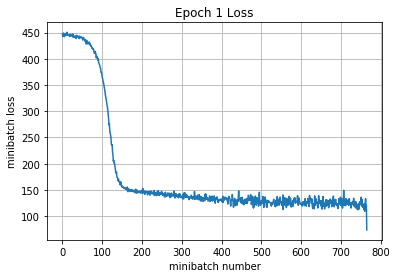

Validation
Epoch 1, Overall loss = 1.97 and accuracy of 0.255
HYPERPARAMETERS:  (0.4, 1e-05, 0.001, 1000, 0.8)
Training
Iteration 0: with minibatch training loss = 7.07 and accuracy of 0
Iteration 100: with minibatch training loss = 3.52 and accuracy of 0.19
Iteration 200: with minibatch training loss = 7.64 and accuracy of 0.14
Iteration 300: with minibatch training loss = 2.13 and accuracy of 0.23
Iteration 400: with minibatch training loss = 1.57 and accuracy of 0.36
Iteration 500: with minibatch training loss = 1.55 and accuracy of 0.44
Iteration 600: with minibatch training loss = 1.79 and accuracy of 0.45
Iteration 700: with minibatch training loss = 1.75 and accuracy of 0.36
Epoch 1, Overall loss = 3.02 and accuracy of 0.301


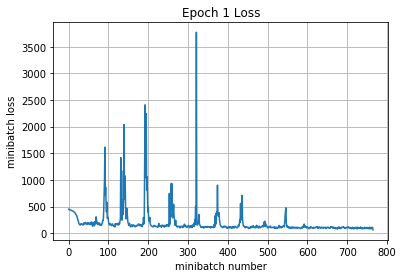

Validation
Epoch 1, Overall loss = 1.59 and accuracy of 0.416
HYPERPARAMETERS:  (0.4, 1e-05, 0.01, 1000, 0.8)
Training
Iteration 0: with minibatch training loss = 6.99 and accuracy of 0
Validation
HYPERPARAMETERS:  (0.4, 0.001, 1e-05, 1000, 0.8)
Training
Iteration 0: with minibatch training loss = 8.5 and accuracy of 0
Iteration 100: with minibatch training loss = 7 and accuracy of 0.094
Iteration 200: with minibatch training loss = 3.82 and accuracy of 0.16
Iteration 300: with minibatch training loss = 3.76 and accuracy of 0.19
Iteration 400: with minibatch training loss = 3.62 and accuracy of 0.2
Iteration 500: with minibatch training loss = 3.33 and accuracy of 0.44
Iteration 600: with minibatch training loss = 3.52 and accuracy of 0.38
Iteration 700: with minibatch training loss = 3.37 and accuracy of 0.28
Epoch 1, Overall loss = 4.25 and accuracy of 0.253


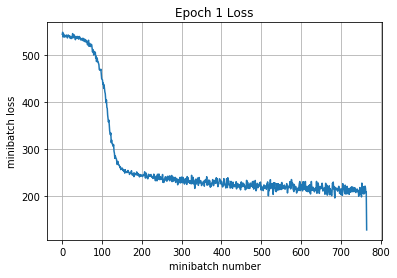

Validation
Epoch 1, Overall loss = 3.29 and accuracy of 0.359
HYPERPARAMETERS:  (0.4, 0.001, 0.001, 1000, 0.8)
Training
Iteration 0: with minibatch training loss = 8.79 and accuracy of 0
Iteration 100: with minibatch training loss = 21.3 and accuracy of 0
Iteration 200: with minibatch training loss = 6.21 and accuracy of 0.062
Iteration 300: with minibatch training loss = 3.86 and accuracy of 0.25
Iteration 400: with minibatch training loss = 2.79 and accuracy of 0.3
Iteration 500: with minibatch training loss = 3.8 and accuracy of 0.25
Iteration 600: with minibatch training loss = 2.4 and accuracy of 0.42
Iteration 700: with minibatch training loss = 2.3 and accuracy of 0.3
Epoch 1, Overall loss = 4.04 and accuracy of 0.282


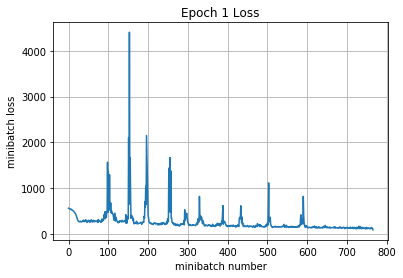

Validation
Epoch 1, Overall loss = 2.19 and accuracy of 0.318
HYPERPARAMETERS:  (0.4, 0.001, 0.01, 1000, 0.8)
Training
Iteration 0: with minibatch training loss = 8.53 and accuracy of 0
Validation
HYPERPARAMETERS:  (0.4, 0.01, 1e-05, 1000, 0.8)
Training
Iteration 0: with minibatch training loss = 23.5 and accuracy of 0.016
Iteration 100: with minibatch training loss = 22 and accuracy of 0.016
Iteration 200: with minibatch training loss = 18.6 and accuracy of 0.17
Iteration 300: with minibatch training loss = 18.1 and accuracy of 0.19
Iteration 400: with minibatch training loss = 17.8 and accuracy of 0.27
Iteration 500: with minibatch training loss = 17.1 and accuracy of 0.39
Iteration 600: with minibatch training loss = 16.7 and accuracy of 0.41
Iteration 700: with minibatch training loss = 16.4 and accuracy of 0.41
Epoch 1, Overall loss = 18.4 and accuracy of 0.245


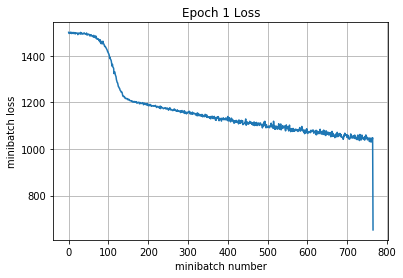

Validation
Epoch 1, Overall loss = 16.3 and accuracy of 0.356
HYPERPARAMETERS:  (0.4, 0.01, 0.001, 1000, 0.8)
Training
Iteration 0: with minibatch training loss = 23.5 and accuracy of 0
Iteration 100: with minibatch training loss = 25.9 and accuracy of 0.031
Iteration 200: with minibatch training loss = 9.71 and accuracy of 0.17
Iteration 300: with minibatch training loss = 5.36 and accuracy of 0.41
Iteration 400: with minibatch training loss = 3.95 and accuracy of 0.22
Iteration 500: with minibatch training loss = 2.7 and accuracy of 0.31
Iteration 600: with minibatch training loss = 2.15 and accuracy of 0.36
Iteration 700: with minibatch training loss = 1.8 and accuracy of 0.53
Epoch 1, Overall loss = 7.85 and accuracy of 0.287


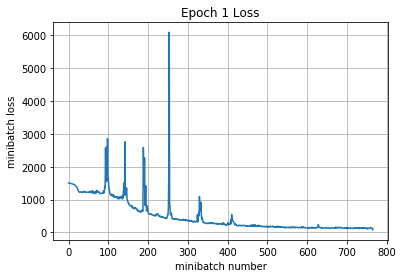

Validation
Epoch 1, Overall loss = 2.27 and accuracy of 0.312
HYPERPARAMETERS:  (0.4, 0.01, 0.01, 1000, 0.8)
Training
Iteration 0: with minibatch training loss = 23.8 and accuracy of 0
Validation
HYPERPARAMETERS:  (0.6, 1e-05, 1e-05, 1000, 0.8)
Training
Iteration 0: with minibatch training loss = 7 and accuracy of 0
Iteration 100: with minibatch training loss = 5.81 and accuracy of 0.078
Iteration 200: with minibatch training loss = 2.21 and accuracy of 0.2
Iteration 300: with minibatch training loss = 2.08 and accuracy of 0.17
Iteration 400: with minibatch training loss = 1.89 and accuracy of 0.41
Iteration 500: with minibatch training loss = 1.9 and accuracy of 0.31
Iteration 600: with minibatch training loss = 1.76 and accuracy of 0.41
Iteration 700: with minibatch training loss = 1.87 and accuracy of 0.34
Epoch 1, Overall loss = 2.66 and accuracy of 0.262


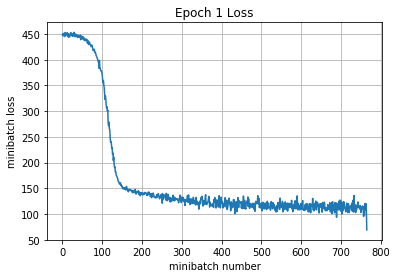

Validation
Epoch 1, Overall loss = 1.76 and accuracy of 0.346
HYPERPARAMETERS:  (0.6, 1e-05, 0.001, 1000, 0.8)
Training
Iteration 0: with minibatch training loss = 7.23 and accuracy of 0
Iteration 100: with minibatch training loss = 7.62 and accuracy of 0.16
Iteration 200: with minibatch training loss = 2.18 and accuracy of 0.34
Iteration 300: with minibatch training loss = 2.11 and accuracy of 0.27
Iteration 400: with minibatch training loss = 1.52 and accuracy of 0.44
Iteration 500: with minibatch training loss = 1.54 and accuracy of 0.39
Iteration 600: with minibatch training loss = 1.75 and accuracy of 0.41
Iteration 700: with minibatch training loss = 1.59 and accuracy of 0.41
Epoch 1, Overall loss = 2.97 and accuracy of 0.342


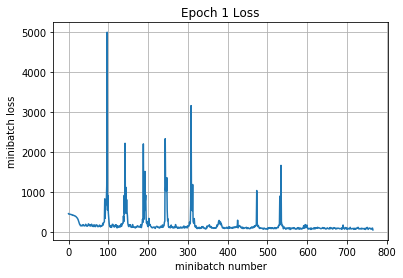

Validation
Epoch 1, Overall loss = 1.48 and accuracy of 0.464
HYPERPARAMETERS:  (0.6, 1e-05, 0.01, 1000, 0.8)
Training
Iteration 0: with minibatch training loss = 6.97 and accuracy of 0
Validation
HYPERPARAMETERS:  (0.6, 0.001, 1e-05, 1000, 0.8)
Training
Iteration 0: with minibatch training loss = 8.7 and accuracy of 0
Iteration 100: with minibatch training loss = 7.84 and accuracy of 0.094
Iteration 200: with minibatch training loss = 3.91 and accuracy of 0.062
Iteration 300: with minibatch training loss = 3.66 and accuracy of 0.22
Iteration 400: with minibatch training loss = 3.58 and accuracy of 0.23
Iteration 500: with minibatch training loss = 3.29 and accuracy of 0.47
Iteration 600: with minibatch training loss = 3.39 and accuracy of 0.27
Iteration 700: with minibatch training loss = 3.32 and accuracy of 0.34
Epoch 1, Overall loss = 4.33 and accuracy of 0.263


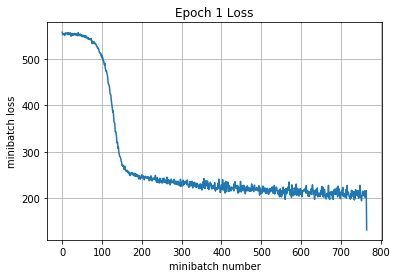

Validation
Epoch 1, Overall loss = 3.23 and accuracy of 0.403
HYPERPARAMETERS:  (0.6, 0.001, 0.001, 1000, 0.8)
Training
Iteration 0: with minibatch training loss = 8.73 and accuracy of 0
Iteration 100: with minibatch training loss = 12 and accuracy of 0.12
Iteration 200: with minibatch training loss = 3.46 and accuracy of 0.28
Iteration 300: with minibatch training loss = 2.94 and accuracy of 0.31
Iteration 400: with minibatch training loss = 2.92 and accuracy of 0.33
Iteration 500: with minibatch training loss = 5.54 and accuracy of 0.34
Iteration 600: with minibatch training loss = 1.92 and accuracy of 0.53
Iteration 700: with minibatch training loss = 1.81 and accuracy of 0.44
Epoch 1, Overall loss = 4.26 and accuracy of 0.312


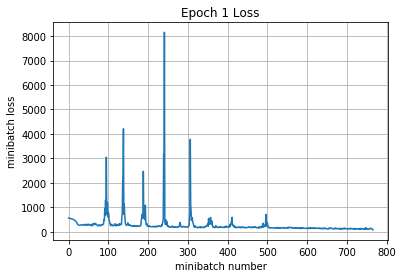

Validation
Epoch 1, Overall loss = 1.96 and accuracy of 0.42
HYPERPARAMETERS:  (0.6, 0.001, 0.01, 1000, 0.8)
Training
Iteration 0: with minibatch training loss = 8.72 and accuracy of 0
Validation
HYPERPARAMETERS:  (0.6, 0.01, 1e-05, 1000, 0.8)
Training
Iteration 0: with minibatch training loss = 23.5 and accuracy of 0
Iteration 100: with minibatch training loss = 22.6 and accuracy of 0.094
Iteration 200: with minibatch training loss = 18.6 and accuracy of 0.22
Iteration 300: with minibatch training loss = 18.1 and accuracy of 0.19
Iteration 400: with minibatch training loss = 17.6 and accuracy of 0.34
Iteration 500: with minibatch training loss = 17.3 and accuracy of 0.33
Iteration 600: with minibatch training loss = 16.8 and accuracy of 0.38
Iteration 700: with minibatch training loss = 16.5 and accuracy of 0.39
Epoch 1, Overall loss = 18.4 and accuracy of 0.243


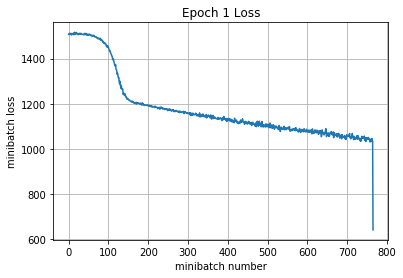

Validation
Epoch 1, Overall loss = 16.2 and accuracy of 0.373
HYPERPARAMETERS:  (0.6, 0.01, 0.001, 1000, 0.8)
Training
Iteration 0: with minibatch training loss = 23.5 and accuracy of 0
Iteration 100: with minibatch training loss = 22.2 and accuracy of 0.19
Iteration 200: with minibatch training loss = 8.58 and accuracy of 0.16
Iteration 300: with minibatch training loss = 4.83 and accuracy of 0.33
Iteration 400: with minibatch training loss = 4.22 and accuracy of 0.38
Iteration 500: with minibatch training loss = 2.64 and accuracy of 0.38
Iteration 600: with minibatch training loss = 2.3 and accuracy of 0.44
Iteration 700: with minibatch training loss = 1.77 and accuracy of 0.56
Epoch 1, Overall loss = 7.48 and accuracy of 0.303


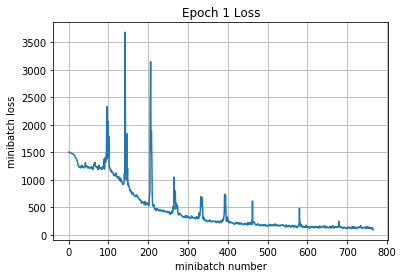

Validation
Epoch 1, Overall loss = 1.99 and accuracy of 0.449
HYPERPARAMETERS:  (0.6, 0.01, 0.01, 1000, 0.8)
Training
Iteration 0: with minibatch training loss = 23.5 and accuracy of 0
Validation
HYPERPARAMETERS:  (0.8, 1e-05, 1e-05, 1000, 0.8)
Training
Iteration 0: with minibatch training loss = 6.94 and accuracy of 0
Iteration 100: with minibatch training loss = 5.67 and accuracy of 0.16
Iteration 200: with minibatch training loss = 2.13 and accuracy of 0.27
Iteration 300: with minibatch training loss = 1.94 and accuracy of 0.41
Iteration 400: with minibatch training loss = 1.72 and accuracy of 0.48
Iteration 500: with minibatch training loss = 1.86 and accuracy of 0.39
Iteration 600: with minibatch training loss = 1.67 and accuracy of 0.52
Iteration 700: with minibatch training loss = 1.53 and accuracy of 0.45
Epoch 1, Overall loss = 2.58 and accuracy of 0.293


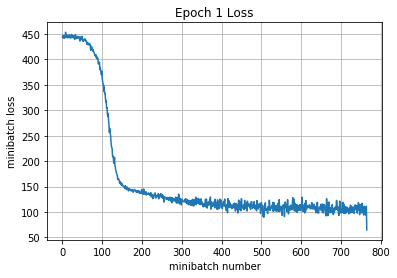

Validation
Epoch 1, Overall loss = 1.61 and accuracy of 0.426
HYPERPARAMETERS:  (0.8, 1e-05, 0.001, 1000, 0.8)
Training
Iteration 0: with minibatch training loss = 6.91 and accuracy of 0
Iteration 100: with minibatch training loss = 3.27 and accuracy of 0.17
Iteration 200: with minibatch training loss = 3.18 and accuracy of 0.16
Iteration 300: with minibatch training loss = 2.19 and accuracy of 0.28
Iteration 400: with minibatch training loss = 1.86 and accuracy of 0.34
Iteration 500: with minibatch training loss = 1.66 and accuracy of 0.45
Iteration 600: with minibatch training loss = 1.62 and accuracy of 0.38
Iteration 700: with minibatch training loss = 1.59 and accuracy of 0.39
Epoch 1, Overall loss = 3.15 and accuracy of 0.329


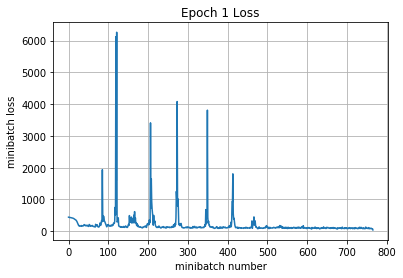

Validation
Epoch 1, Overall loss = 1.33 and accuracy of 0.519
HYPERPARAMETERS:  (0.8, 1e-05, 0.01, 1000, 0.8)
Training
Iteration 0: with minibatch training loss = 7.14 and accuracy of 0.016
Validation
HYPERPARAMETERS:  (0.8, 0.001, 1e-05, 1000, 0.8)
Training
Iteration 0: with minibatch training loss = 8.55 and accuracy of 0.016
Iteration 100: with minibatch training loss = 7.21 and accuracy of 0.12
Iteration 200: with minibatch training loss = 3.83 and accuracy of 0.22
Iteration 300: with minibatch training loss = 3.71 and accuracy of 0.25
Iteration 400: with minibatch training loss = 3.42 and accuracy of 0.28
Iteration 500: with minibatch training loss = 3.41 and accuracy of 0.42
Iteration 600: with minibatch training loss = 3.5 and accuracy of 0.34
Iteration 700: with minibatch training loss = 3.27 and accuracy of 0.34
Epoch 1, Overall loss = 4.24 and accuracy of 0.266


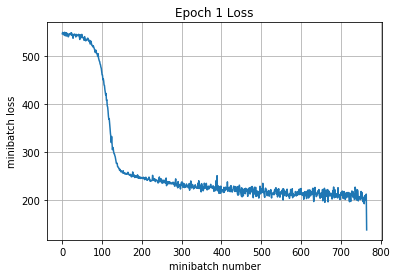

Validation
Epoch 1, Overall loss = 3.22 and accuracy of 0.386
HYPERPARAMETERS:  (0.8, 0.001, 0.001, 1000, 0.8)
Training
Iteration 0: with minibatch training loss = 8.72 and accuracy of 0
Iteration 100: with minibatch training loss = 5.13 and accuracy of 0.16
Iteration 200: with minibatch training loss = 3.82 and accuracy of 0.27
Iteration 300: with minibatch training loss = 11.3 and accuracy of 0.078
Iteration 400: with minibatch training loss = 2.7 and accuracy of 0.47
Iteration 500: with minibatch training loss = 2.21 and accuracy of 0.53
Iteration 600: with minibatch training loss = 2.49 and accuracy of 0.31
Iteration 700: with minibatch training loss = 1.92 and accuracy of 0.42
Epoch 1, Overall loss = 3.98 and accuracy of 0.314


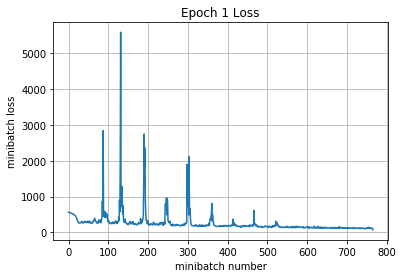

Validation
Epoch 1, Overall loss = 1.73 and accuracy of 0.491
HYPERPARAMETERS:  (0.8, 0.001, 0.01, 1000, 0.8)
Training
Iteration 0: with minibatch training loss = 8.49 and accuracy of 0
Validation
HYPERPARAMETERS:  (0.8, 0.01, 1e-05, 1000, 0.8)
Training
Iteration 0: with minibatch training loss = 23.5 and accuracy of 0
Iteration 100: with minibatch training loss = 22.6 and accuracy of 0.17
Iteration 200: with minibatch training loss = 18.5 and accuracy of 0.23
Iteration 300: with minibatch training loss = 18 and accuracy of 0.3
Iteration 400: with minibatch training loss = 17.5 and accuracy of 0.34
Iteration 500: with minibatch training loss = 17.1 and accuracy of 0.44
Iteration 600: with minibatch training loss = 16.9 and accuracy of 0.16
Iteration 700: with minibatch training loss = 16.5 and accuracy of 0.34
Epoch 1, Overall loss = 18.4 and accuracy of 0.275


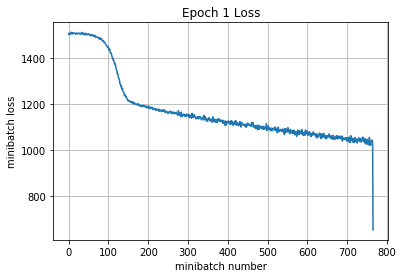

Validation
Epoch 1, Overall loss = 16.2 and accuracy of 0.408
HYPERPARAMETERS:  (0.8, 0.01, 0.001, 1000, 0.8)
Training
Iteration 0: with minibatch training loss = 23.7 and accuracy of 0
Iteration 100: with minibatch training loss = 18.9 and accuracy of 0.25
Iteration 200: with minibatch training loss = 9.45 and accuracy of 0.34
Iteration 300: with minibatch training loss = 10.4 and accuracy of 0.14
Iteration 400: with minibatch training loss = 3.7 and accuracy of 0.39
Iteration 500: with minibatch training loss = 2.86 and accuracy of 0.42
Iteration 600: with minibatch training loss = 2.01 and accuracy of 0.47
Iteration 700: with minibatch training loss = 2 and accuracy of 0.48
Epoch 1, Overall loss = 7.86 and accuracy of 0.321


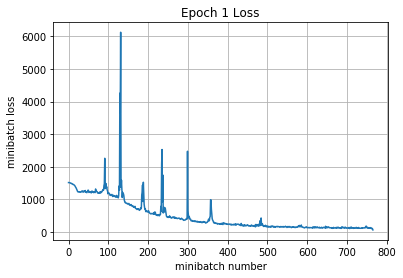

Validation
Epoch 1, Overall loss = 2 and accuracy of 0.47
HYPERPARAMETERS:  (0.8, 0.01, 0.01, 1000, 0.8)
Training
Iteration 0: with minibatch training loss = 23.5 and accuracy of 0
Validation
HYPERPARAMETERS:  (0.9, 1e-05, 1e-05, 1000, 0.8)
Training
Iteration 0: with minibatch training loss = 7.07 and accuracy of 0
Iteration 100: with minibatch training loss = 5.9 and accuracy of 0.2
Iteration 200: with minibatch training loss = 2.28 and accuracy of 0.14
Iteration 300: with minibatch training loss = 2.05 and accuracy of 0.22
Iteration 400: with minibatch training loss = 2.05 and accuracy of 0.23
Iteration 500: with minibatch training loss = 1.81 and accuracy of 0.31
Iteration 600: with minibatch training loss = 2.01 and accuracy of 0.39
Iteration 700: with minibatch training loss = 1.74 and accuracy of 0.38
Epoch 1, Overall loss = 2.7 and accuracy of 0.258


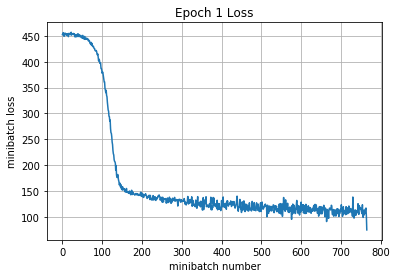

Validation
Epoch 1, Overall loss = 1.68 and accuracy of 0.394
HYPERPARAMETERS:  (0.9, 1e-05, 0.001, 1000, 0.8)
Training
Iteration 0: with minibatch training loss = 7.02 and accuracy of 0
Iteration 100: with minibatch training loss = 3.45 and accuracy of 0.2
Iteration 200: with minibatch training loss = 1.75 and accuracy of 0.36
Iteration 300: with minibatch training loss = 2.96 and accuracy of 0.27
Iteration 400: with minibatch training loss = 1.95 and accuracy of 0.39
Iteration 500: with minibatch training loss = 1.92 and accuracy of 0.38
Iteration 600: with minibatch training loss = 1.49 and accuracy of 0.53
Iteration 700: with minibatch training loss = 1.42 and accuracy of 0.44
Epoch 1, Overall loss = 2.85 and accuracy of 0.339


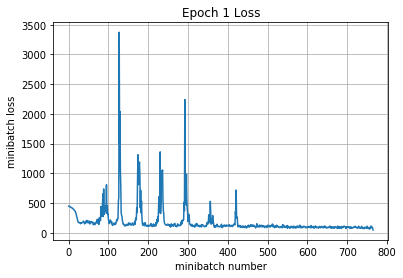

Validation
Epoch 1, Overall loss = 1.27 and accuracy of 0.546
HYPERPARAMETERS:  (0.9, 1e-05, 0.01, 1000, 0.8)
Training
Iteration 0: with minibatch training loss = 6.93 and accuracy of 0
Validation
HYPERPARAMETERS:  (0.9, 0.001, 1e-05, 1000, 0.8)
Training
Iteration 0: with minibatch training loss = 8.5 and accuracy of 0
Iteration 100: with minibatch training loss = 7.14 and accuracy of 0.078
Iteration 200: with minibatch training loss = 3.8 and accuracy of 0.17
Iteration 300: with minibatch training loss = 3.7 and accuracy of 0.23
Iteration 400: with minibatch training loss = 3.47 and accuracy of 0.25
Iteration 500: with minibatch training loss = 3.43 and accuracy of 0.33
Iteration 600: with minibatch training loss = 3.16 and accuracy of 0.41
Iteration 700: with minibatch training loss = 2.99 and accuracy of 0.52
Epoch 1, Overall loss = 4.18 and accuracy of 0.282


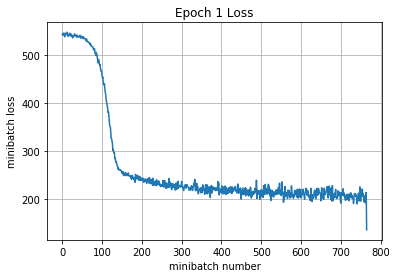

Validation
Epoch 1, Overall loss = 3.2 and accuracy of 0.401
HYPERPARAMETERS:  (0.9, 0.001, 0.001, 1000, 0.8)
Training
Iteration 0: with minibatch training loss = 8.69 and accuracy of 0
Iteration 100: with minibatch training loss = 4.21 and accuracy of 0.2
Iteration 200: with minibatch training loss = 3.37 and accuracy of 0.36
Iteration 300: with minibatch training loss = 10.3 and accuracy of 0.16
Iteration 400: with minibatch training loss = 2.56 and accuracy of 0.45
Iteration 500: with minibatch training loss = 2.36 and accuracy of 0.41
Iteration 600: with minibatch training loss = 1.92 and accuracy of 0.5
Iteration 700: with minibatch training loss = 1.9 and accuracy of 0.41
Epoch 1, Overall loss = 3.89 and accuracy of 0.338


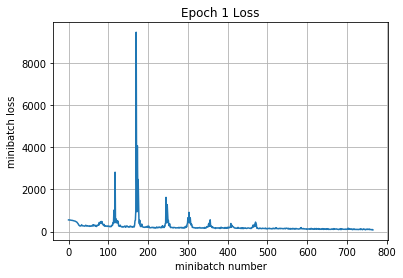

Validation
Epoch 1, Overall loss = 1.72 and accuracy of 0.497
HYPERPARAMETERS:  (0.9, 0.001, 0.01, 1000, 0.8)
Training
Iteration 0: with minibatch training loss = 8.71 and accuracy of 0
Validation
HYPERPARAMETERS:  (0.9, 0.01, 1e-05, 1000, 0.8)
Training
Iteration 0: with minibatch training loss = 23.4 and accuracy of 0
Iteration 100: with minibatch training loss = 22.5 and accuracy of 0.16
Iteration 200: with minibatch training loss = 18.5 and accuracy of 0.28
Iteration 300: with minibatch training loss = 18 and accuracy of 0.22
Iteration 400: with minibatch training loss = 17.6 and accuracy of 0.31
Iteration 500: with minibatch training loss = 17.2 and accuracy of 0.42
Iteration 600: with minibatch training loss = 16.8 and accuracy of 0.28
Iteration 700: with minibatch training loss = 16.4 and accuracy of 0.38
Epoch 1, Overall loss = 18.3 and accuracy of 0.278


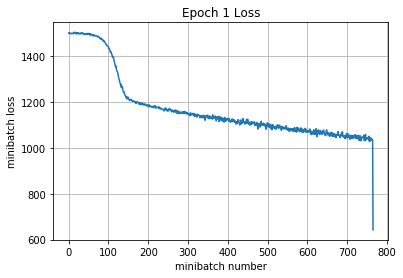

Validation
Epoch 1, Overall loss = 16.1 and accuracy of 0.401
HYPERPARAMETERS:  (0.9, 0.01, 0.001, 1000, 0.8)
Training
Iteration 0: with minibatch training loss = 23.6 and accuracy of 0
Iteration 100: with minibatch training loss = 21.3 and accuracy of 0.27
Iteration 200: with minibatch training loss = 10.6 and accuracy of 0.14
Iteration 300: with minibatch training loss = 5.36 and accuracy of 0.33
Iteration 400: with minibatch training loss = 3.27 and accuracy of 0.44
Iteration 500: with minibatch training loss = 4.98 and accuracy of 0.28
Iteration 600: with minibatch training loss = 2.42 and accuracy of 0.45
Iteration 700: with minibatch training loss = 2.07 and accuracy of 0.45
Epoch 1, Overall loss = 7.82 and accuracy of 0.33


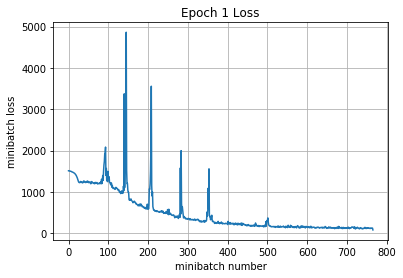

Validation
Epoch 1, Overall loss = 2.16 and accuracy of 0.397
HYPERPARAMETERS:  (0.9, 0.01, 0.01, 1000, 0.8)
Training
Iteration 0: with minibatch training loss = 23.5 and accuracy of 0
Validation


In [71]:
L = [1e-5, 1e-3, 1e-2]
for dropout_strength in [.4, .6, .8, .9]:
    for reg in L:
        for starter_learning_rate in L:
            def my_model(X,y,is_training):
    #hyperparameters


                Wconv1 = tf.get_variable("Wconv1", shape=[2, 2, 3, 10])
                bconv1 = tf.get_variable("bconv1", shape=[10])
                betabatch1 = tf.get_variable("betabatch", shape = [10])
                gammabatch1 = tf.get_variable("gammabatch", shape = [10])

                Wconv2 = tf.get_variable("Wconv2", shape=[5, 5, 10, 60])
                bconv2 = tf.get_variable("bconv2", shape=[60])
                betabatch2 = tf.get_variable("betabatch2", shape = [60])
                gammabatch2 = tf.get_variable("gammabatch2", shape = [60])

                Wconv3 = tf.get_variable("Wconv3", shape=[5, 5, 60, 70])
                bconv3 = tf.get_variable("bconv3", shape=[70])

                Wconv4 = tf.get_variable("Wconv4", shape=[3, 3, 70, 80])
                bconv4 = tf.get_variable("bconv4", shape=[80])

                Wconv5 = tf.get_variable("Wconv5", shape=[3, 3, 80, 90])
                bconv5 = tf.get_variable("bconv5", shape=[90])


                W6 = tf.get_variable("W6", shape=[6*6*90, 800])
                b6 = tf.get_variable("b6", shape=[800])
                W7 = tf.get_variable("W7", shape=[800,900])
                b7 = tf.get_variable("b7", shape=[900])
                W8 = tf.get_variable("W8", shape=[900,1000])
                b8 = tf.get_variable("b8", shape=[1000])

                ### CONV1 ###

                conv1 = tf.nn.conv2d(X, Wconv1, strides=[1,1,1,1], padding='VALID') + bconv1
                relu1 = tf.nn.relu(conv1)
                relu1 = tf.nn.dropout(relu1, dropout_strength)
                mpool1 = tf.nn.max_pool(relu1, ksize=[1, 2, 2, 1], strides=[1, 1, 1, 1], padding='VALID' )
                meanbatch1, variancebatch1 = tf.nn.moments(mpool1, axes = [0,1,2], keep_dims=True)
                norm1 = tf.nn.batch_normalization(mpool1, meanbatch1, variancebatch1, betabatch1, gammabatch1, 1e-5)

                ### CONV2 ###

                conv2 = tf.nn.conv2d(norm1, Wconv2, strides=[1,1,1,1], padding='SAME') + bconv2
                relu2 = tf.nn.relu(conv2)
                relu2 = tf.nn.dropout(relu2, dropout_strength)
                mpool2 = tf.nn.max_pool(relu2, ksize=[1, 4, 4, 1], strides=[1, 1, 1, 1], padding='VALID' )
                meanbatch2, variancebatch2 = tf.nn.moments(mpool2, axes = [0,1,2], keep_dims=True)
                norm2 = tf.nn.batch_normalization(mpool2, meanbatch2, variancebatch2, betabatch2, gammabatch2, 1e-5)

                ### CONV3 ###
                # Padding
            #     paddings = tf.constant()
            #     norm2 = tf.pad(norm2, paddings, "CONSTANT")
                norm2 = tf.image.resize_image_with_crop_or_pad(
                norm2,
                29,
                29
            )
                conv3 = tf.nn.conv2d(norm2, Wconv3, strides=[1,2,2,1], padding='VALID') + bconv3
                conv4 = tf.nn.conv2d(conv3, Wconv4, strides=[1,1,1,1], padding='SAME') + bconv4
                conv5 = tf.nn.conv2d(conv4, Wconv5, strides=[1,1,1,1], padding='SAME') + bconv5
                mpool3 = tf.nn.max_pool(conv5, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1], padding='VALID' )

                ### FC6, FC7, FC8 ###
                mpool3_flat = tf.reshape(mpool3,[-1,6*6*90])
                fc6 = tf.matmul(mpool3_flat,W6) + b6
                fc7 = tf.matmul(fc6,W7) + b7
                y_out = tf.matmul(fc7,W8) + b8
                regularizers = (tf.nn.l2_loss(Wconv1) + tf.nn.l2_loss(Wconv2) + tf.nn.l2_loss(Wconv3) +  tf.nn.l2_loss(Wconv4) +\
                            tf.nn.l2_loss(Wconv5) + tf.nn.l2_loss(W6) + tf.nn.l2_loss(W7) + tf.nn.l2_loss(W8))
                return y_out, regularizers
            # hyperparameters
#             reg = 1e-3
#             starter_learning_rate = 5e-2
#             decay_steps = 1000
#             decay_rate = 0.8
            tf.reset_default_graph()

            X = tf.placeholder(tf.float32, [None, 32, 32, 3])
            y = tf.placeholder(tf.int64, [None])
            is_training = tf.placeholder(tf.bool)

            y_out, regularizers = my_model(X,y,is_training)

            # loss function with L2 regularization
            total_loss = tf.losses.softmax_cross_entropy(tf.one_hot(y,1000),logits=y_out)
            mean_loss = tf.reduce_mean(total_loss)
            mean_loss = tf.reduce_mean(mean_loss + reg * regularizers)

            # define our optimizer

            global_step = tf.Variable(0, trainable=False)
            learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
                                                       decay_steps, decay_rate, staircase=True)
            optimizer = tf.train.AdamOptimizer(learning_rate) # select optimizer and set learning rate

            # batch normalization in tensorflow requires this extra dependency
            extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
            with tf.control_dependencies(extra_update_ops):
                train_step = optimizer.minimize(mean_loss)
                
            print('HYPERPARAMETERS: ', (dropout_strength, reg, starter_learning_rate, decay_steps, decay_rate))
            sess = tf.Session()

            sess.run(tf.global_variables_initializer())
            print('Training')
            run_model(sess,y_out,mean_loss,X_train,y_train,1,64,100,train_step,True)
            print('Validation')
            run_model(sess,y_out,mean_loss,X_val,y_val,1,64)
                
                
                
                

In [32]:
# Feel free to play with this cell

def my_model(X,y,is_training):
    #hyperparameters
    dropout_strength = .8
    
    
    Wconv1 = tf.get_variable("Wconv1", shape=[2, 2, 3, 10])
    bconv1 = tf.get_variable("bconv1", shape=[10])
    betabatch1 = tf.get_variable("betabatch", shape = [10])
    gammabatch1 = tf.get_variable("gammabatch", shape = [10])
    
    Wconv2 = tf.get_variable("Wconv2", shape=[5, 5, 10, 60])
    bconv2 = tf.get_variable("bconv2", shape=[60])
    betabatch2 = tf.get_variable("betabatch2", shape = [60])
    gammabatch2 = tf.get_variable("gammabatch2", shape = [60])
    
    Wconv3 = tf.get_variable("Wconv3", shape=[5, 5, 60, 70])
    bconv3 = tf.get_variable("bconv3", shape=[70])
    
    Wconv4 = tf.get_variable("Wconv4", shape=[3, 3, 70, 80])
    bconv4 = tf.get_variable("bconv4", shape=[80])
    
    Wconv5 = tf.get_variable("Wconv5", shape=[3, 3, 80, 90])
    bconv5 = tf.get_variable("bconv5", shape=[90])
    
    
    W6 = tf.get_variable("W6", shape=[6*6*90, 800])
    b6 = tf.get_variable("b6", shape=[800])
    W7 = tf.get_variable("W7", shape=[800,900])
    b7 = tf.get_variable("b7", shape=[900])
    W8 = tf.get_variable("W8", shape=[900,1000])
    b8 = tf.get_variable("b8", shape=[1000])

    ### CONV1 ###
    
    conv1 = tf.nn.conv2d(X, Wconv1, strides=[1,1,1,1], padding='VALID') + bconv1
    relu1 = tf.nn.relu(conv1)
    relu1 = tf.nn.dropout(relu1, dropout_strength)
    mpool1 = tf.nn.max_pool(relu1, ksize=[1, 2, 2, 1], strides=[1, 1, 1, 1], padding='VALID' )
    meanbatch1, variancebatch1 = tf.nn.moments(mpool1, axes = [0,1,2], keep_dims=True)
    norm1 = tf.nn.batch_normalization(mpool1, meanbatch1, variancebatch1, betabatch1, gammabatch1, 1e-5)
    
    ### CONV2 ###
    
    conv2 = tf.nn.conv2d(norm1, Wconv2, strides=[1,1,1,1], padding='SAME') + bconv2
    relu2 = tf.nn.relu(conv2)
    relu2 = tf.nn.dropout(relu2, dropout_strength)
    mpool2 = tf.nn.max_pool(relu2, ksize=[1, 4, 4, 1], strides=[1, 1, 1, 1], padding='VALID' )
    meanbatch2, variancebatch2 = tf.nn.moments(mpool2, axes = [0,1,2], keep_dims=True)
    norm2 = tf.nn.batch_normalization(mpool2, meanbatch2, variancebatch2, betabatch2, gammabatch2, 1e-5)
    
    ### CONV3 ###
    # Padding
#     paddings = tf.constant()
#     norm2 = tf.pad(norm2, paddings, "CONSTANT")
    norm2 = tf.image.resize_image_with_crop_or_pad(
    norm2,
    29,
    29
)
    conv3 = tf.nn.conv2d(norm2, Wconv3, strides=[1,2,2,1], padding='VALID') + bconv3
    conv4 = tf.nn.conv2d(conv3, Wconv4, strides=[1,1,1,1], padding='SAME') + bconv4
    conv5 = tf.nn.conv2d(conv4, Wconv5, strides=[1,1,1,1], padding='SAME') + bconv5
    mpool3 = tf.nn.max_pool(conv5, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1], padding='VALID' )
    
    ### FC6, FC7, FC8 ###
    mpool3_flat = tf.reshape(mpool3,[-1,6*6*90])
    fc6 = tf.matmul(mpool3_flat,W6) + b6
    fc7 = tf.matmul(fc6,W7) + b7
    y_out = tf.matmul(fc7,W8) + b8
    regularizers = (tf.nn.l2_loss(Wconv1) + tf.nn.l2_loss(Wconv2) + tf.nn.l2_loss(Wconv3) +  tf.nn.l2_loss(Wconv4) +\
                tf.nn.l2_loss(Wconv5) + tf.nn.l2_loss(W6) + tf.nn.l2_loss(W7) + tf.nn.l2_loss(W8))
    return y_out, regularizers
    
# hyperparameters
reg = 5e-3
starter_learning_rate = 5e-4
decay_steps = 1000
decay_rate = 0.8
tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, 32, 32, 3])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

y_out, regularizers = my_model(X,y,is_training)

# loss function with L2 regularization
total_loss = tf.losses.softmax_cross_entropy(tf.one_hot(y,1000),logits=y_out)
mean_loss = tf.reduce_mean(total_loss)
mean_loss = tf.reduce_mean(mean_loss + reg * regularizers)

# define our optimizer

global_step = tf.Variable(0, trainable=False)
learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
                                           decay_steps, decay_rate, staircase=True)
optimizer = tf.train.AdamOptimizer(learning_rate) # select optimizer and set learning rate

# batch normalization in tensorflow requires this extra dependency
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(mean_loss)

Training
Iteration 0: with minibatch training loss = 15.2 and accuracy of 0
Iteration 100: with minibatch training loss = 6.84 and accuracy of 0.3
Iteration 200: with minibatch training loss = 5.4 and accuracy of 0.45
Iteration 300: with minibatch training loss = 4.26 and accuracy of 0.59
Iteration 400: with minibatch training loss = 3.81 and accuracy of 0.48
Iteration 500: with minibatch training loss = 2.96 and accuracy of 0.59
Iteration 600: with minibatch training loss = 2.87 and accuracy of 0.48
Iteration 700: with minibatch training loss = 2.35 and accuracy of 0.58
Epoch 1, Overall loss = 4.41 and accuracy of 0.481


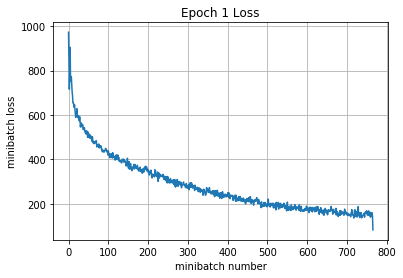

Iteration 800: with minibatch training loss = 2.13 and accuracy of 0.56
Iteration 900: with minibatch training loss = 2.1 and accuracy of 0.56
Iteration 1000: with minibatch training loss = 1.89 and accuracy of 0.58
Iteration 1100: with minibatch training loss = 1.65 and accuracy of 0.61
Iteration 1200: with minibatch training loss = 1.77 and accuracy of 0.58
Iteration 1300: with minibatch training loss = 1.66 and accuracy of 0.62
Iteration 1400: with minibatch training loss = 1.91 and accuracy of 0.53
Iteration 1500: with minibatch training loss = 1.7 and accuracy of 0.66
Epoch 2, Overall loss = 1.82 and accuracy of 0.602


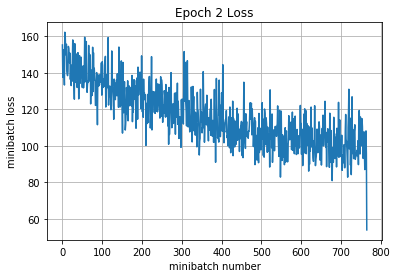

Iteration 1600: with minibatch training loss = 1.63 and accuracy of 0.61
Iteration 1700: with minibatch training loss = 1.54 and accuracy of 0.64
Iteration 1800: with minibatch training loss = 1.65 and accuracy of 0.61
Iteration 1900: with minibatch training loss = 1.42 and accuracy of 0.58
Iteration 2000: with minibatch training loss = 1.24 and accuracy of 0.73
Iteration 2100: with minibatch training loss = 1.4 and accuracy of 0.58
Iteration 2200: with minibatch training loss = 1.35 and accuracy of 0.64
Epoch 3, Overall loss = 1.4 and accuracy of 0.647


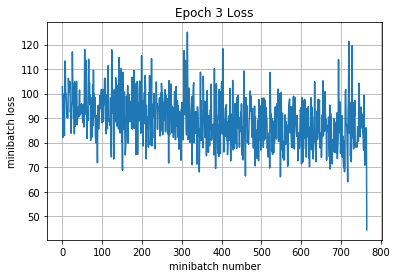

Iteration 2300: with minibatch training loss = 1.37 and accuracy of 0.61
Iteration 2400: with minibatch training loss = 1.37 and accuracy of 0.67
Iteration 2500: with minibatch training loss = 1.31 and accuracy of 0.64
Iteration 2600: with minibatch training loss = 1.23 and accuracy of 0.67
Iteration 2700: with minibatch training loss = 1.18 and accuracy of 0.72
Iteration 2800: with minibatch training loss = 1.45 and accuracy of 0.53
Iteration 2900: with minibatch training loss = 1.35 and accuracy of 0.61
Iteration 3000: with minibatch training loss = 1.45 and accuracy of 0.56
Epoch 4, Overall loss = 1.25 and accuracy of 0.68


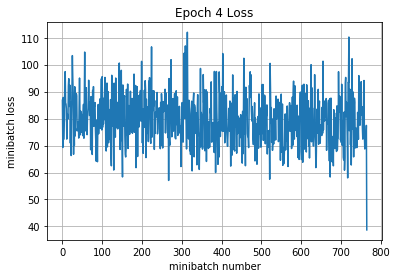

Iteration 3100: with minibatch training loss = 1.25 and accuracy of 0.66
Iteration 3200: with minibatch training loss = 1.24 and accuracy of 0.61
Iteration 3300: with minibatch training loss = 1.22 and accuracy of 0.67
Iteration 3400: with minibatch training loss = 1.1 and accuracy of 0.7
Iteration 3500: with minibatch training loss = 1.14 and accuracy of 0.7
Iteration 3600: with minibatch training loss = 1.07 and accuracy of 0.7
Iteration 3700: with minibatch training loss = 1.05 and accuracy of 0.69
Iteration 3800: with minibatch training loss = 1.01 and accuracy of 0.75
Epoch 5, Overall loss = 1.17 and accuracy of 0.698


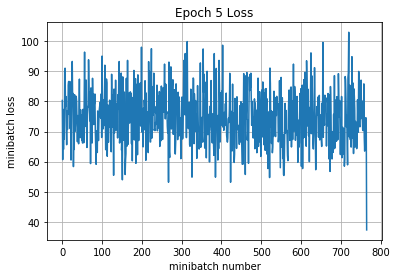

Iteration 3900: with minibatch training loss = 1.3 and accuracy of 0.69
Iteration 4000: with minibatch training loss = 1.06 and accuracy of 0.77
Iteration 4100: with minibatch training loss = 1 and accuracy of 0.77
Iteration 4200: with minibatch training loss = 0.898 and accuracy of 0.8
Iteration 4300: with minibatch training loss = 1.39 and accuracy of 0.64
Iteration 4400: with minibatch training loss = 1.23 and accuracy of 0.73
Iteration 4500: with minibatch training loss = 1.09 and accuracy of 0.73
Epoch 6, Overall loss = 1.13 and accuracy of 0.711


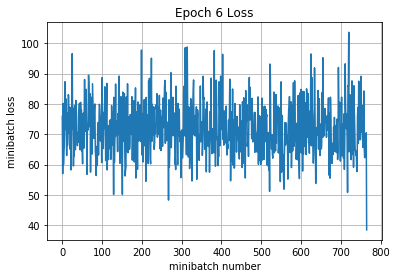

Iteration 4600: with minibatch training loss = 1 and accuracy of 0.77
Iteration 4700: with minibatch training loss = 1.15 and accuracy of 0.67
Iteration 4800: with minibatch training loss = 1.12 and accuracy of 0.75
Iteration 4900: with minibatch training loss = 1.05 and accuracy of 0.72
Iteration 5000: with minibatch training loss = 1.04 and accuracy of 0.77
Iteration 5100: with minibatch training loss = 1.22 and accuracy of 0.67
Iteration 5200: with minibatch training loss = 0.875 and accuracy of 0.84
Iteration 5300: with minibatch training loss = 1.11 and accuracy of 0.72
Epoch 7, Overall loss = 1.09 and accuracy of 0.722


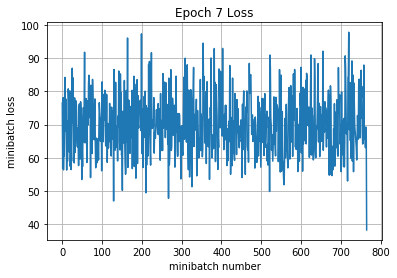

Iteration 5400: with minibatch training loss = 0.941 and accuracy of 0.73
Iteration 5500: with minibatch training loss = 1.05 and accuracy of 0.73
Iteration 5600: with minibatch training loss = 1.17 and accuracy of 0.67
Iteration 5700: with minibatch training loss = 0.891 and accuracy of 0.81
Iteration 5800: with minibatch training loss = 0.989 and accuracy of 0.77
Iteration 5900: with minibatch training loss = 1.06 and accuracy of 0.7
Iteration 6000: with minibatch training loss = 0.876 and accuracy of 0.83
Iteration 6100: with minibatch training loss = 0.976 and accuracy of 0.81
Epoch 8, Overall loss = 1.06 and accuracy of 0.731


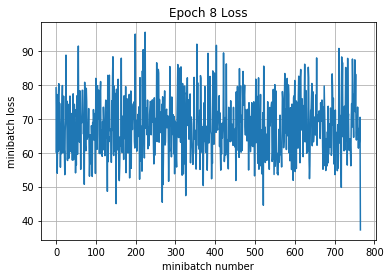

Iteration 6200: with minibatch training loss = 1.14 and accuracy of 0.7
Iteration 6300: with minibatch training loss = 0.984 and accuracy of 0.75
Iteration 6400: with minibatch training loss = 1.05 and accuracy of 0.72
Iteration 6500: with minibatch training loss = 1.11 and accuracy of 0.7
Iteration 6600: with minibatch training loss = 1.29 and accuracy of 0.56
Iteration 6700: with minibatch training loss = 0.893 and accuracy of 0.75
Iteration 6800: with minibatch training loss = 1.12 and accuracy of 0.75
Epoch 9, Overall loss = 1.04 and accuracy of 0.738


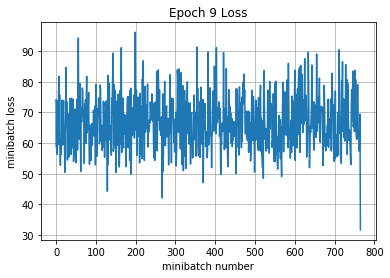

Iteration 6900: with minibatch training loss = 1.15 and accuracy of 0.7
Iteration 7000: with minibatch training loss = 1.02 and accuracy of 0.78
Iteration 7100: with minibatch training loss = 1.11 and accuracy of 0.7
Iteration 7200: with minibatch training loss = 1.23 and accuracy of 0.64
Iteration 7300: with minibatch training loss = 1.01 and accuracy of 0.69
Iteration 7400: with minibatch training loss = 1.03 and accuracy of 0.8
Iteration 7500: with minibatch training loss = 0.972 and accuracy of 0.75
Iteration 7600: with minibatch training loss = 0.875 and accuracy of 0.83
Epoch 10, Overall loss = 1.02 and accuracy of 0.746


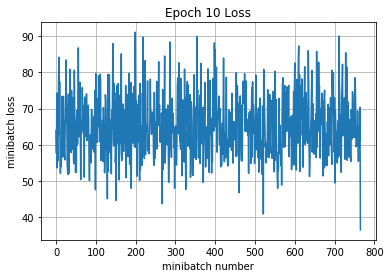

Iteration 7700: with minibatch training loss = 0.993 and accuracy of 0.72
Iteration 7800: with minibatch training loss = 1.11 and accuracy of 0.69
Iteration 7900: with minibatch training loss = 1.06 and accuracy of 0.75
Iteration 8000: with minibatch training loss = 1.08 and accuracy of 0.66
Iteration 8100: with minibatch training loss = 0.875 and accuracy of 0.78
Iteration 8200: with minibatch training loss = 1 and accuracy of 0.73
Iteration 8300: with minibatch training loss = 1.04 and accuracy of 0.66
Iteration 8400: with minibatch training loss = 0.879 and accuracy of 0.78
Epoch 11, Overall loss = 1.01 and accuracy of 0.752


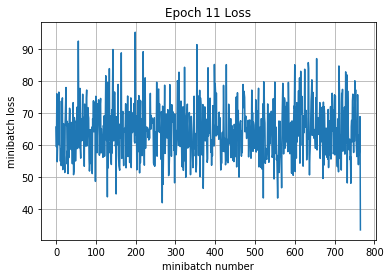

Iteration 8500: with minibatch training loss = 1.05 and accuracy of 0.73
Iteration 8600: with minibatch training loss = 1.01 and accuracy of 0.73
Iteration 8700: with minibatch training loss = 0.91 and accuracy of 0.78
Iteration 8800: with minibatch training loss = 1.08 and accuracy of 0.72
Iteration 8900: with minibatch training loss = 1.12 and accuracy of 0.72
Iteration 9000: with minibatch training loss = 1.05 and accuracy of 0.72
Iteration 9100: with minibatch training loss = 1.09 and accuracy of 0.69
Epoch 12, Overall loss = 0.991 and accuracy of 0.756


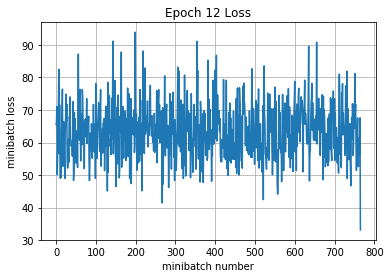

Iteration 9200: with minibatch training loss = 0.89 and accuracy of 0.78
Iteration 9300: with minibatch training loss = 1.06 and accuracy of 0.73
Iteration 9400: with minibatch training loss = 1.11 and accuracy of 0.77
Iteration 9500: with minibatch training loss = 0.869 and accuracy of 0.77
Iteration 9600: with minibatch training loss = 1.02 and accuracy of 0.75
Iteration 9700: with minibatch training loss = 1.01 and accuracy of 0.78
Iteration 9800: with minibatch training loss = 0.968 and accuracy of 0.8
Iteration 9900: with minibatch training loss = 0.953 and accuracy of 0.73
Epoch 13, Overall loss = 0.98 and accuracy of 0.762


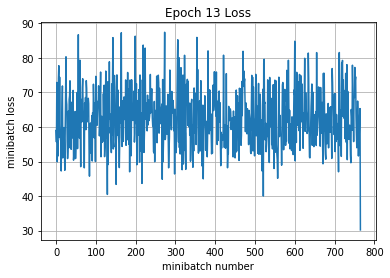

Iteration 10000: with minibatch training loss = 1.05 and accuracy of 0.73
Iteration 10100: with minibatch training loss = 1.13 and accuracy of 0.7
Iteration 10200: with minibatch training loss = 1.05 and accuracy of 0.78
Iteration 10300: with minibatch training loss = 0.909 and accuracy of 0.81
Iteration 10400: with minibatch training loss = 1.02 and accuracy of 0.77
Iteration 10500: with minibatch training loss = 1.06 and accuracy of 0.67
Iteration 10600: with minibatch training loss = 0.979 and accuracy of 0.69
Iteration 10700: with minibatch training loss = 0.971 and accuracy of 0.83
Epoch 14, Overall loss = 0.963 and accuracy of 0.767


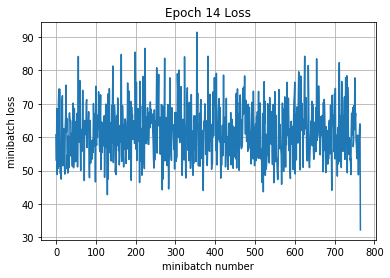

Iteration 10800: with minibatch training loss = 1.06 and accuracy of 0.66
Iteration 10900: with minibatch training loss = 0.871 and accuracy of 0.8
Iteration 11000: with minibatch training loss = 0.942 and accuracy of 0.78
Iteration 11100: with minibatch training loss = 0.779 and accuracy of 0.86
Iteration 11200: with minibatch training loss = 1 and accuracy of 0.72
Iteration 11300: with minibatch training loss = 0.953 and accuracy of 0.8
Iteration 11400: with minibatch training loss = 0.925 and accuracy of 0.81
Epoch 15, Overall loss = 0.953 and accuracy of 0.771


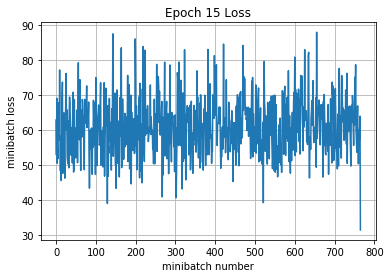

Validation
Epoch 1, Overall loss = 1.07 and accuracy of 0.738


(1.069522479057312, 0.738)

In [33]:
# Feel free to play with this cell
# This default code creates a session
# and trains your model for 10 epochs
# then prints the validation set accuracy
sess = tf.Session()

sess.run(tf.global_variables_initializer())
print('Training')
run_model(sess,y_out,mean_loss,X_train,y_train,15,64,100,train_step,True)
print('Validation')
run_model(sess,y_out,mean_loss,X_val,y_val,1,64)

In [34]:
# Test your model here, and make sure 
# the output of this cell is the accuracy
# of your best model on the training and val sets
# We're looking for >= 70% accuracy on Validation
print('Training')
run_model(sess,y_out,mean_loss,X_train,y_train,1,64)
print('Validation')
run_model(sess,y_out,mean_loss,X_val,y_val,1,64)

Training
Epoch 1, Overall loss = 0.919 and accuracy of 0.781
Validation
Epoch 1, Overall loss = 1.06 and accuracy of 0.732


(1.064991117477417, 0.732)

### Describe what you did here
In this cell you should also write an explanation of what you did, any additional features that you implemented, and any visualizations or graphs that you make in the process of training and evaluating your network

_Tell us here_

### Test Set - Do this only once
Now that we've gotten a result that we're happy with, we test our final model on the test set. This would be the score we would achieve on a competition. Think about how this compares to your validation set accuracy.

In [35]:
print('Test')
run_model(sess,y_out,mean_loss,X_test,y_test,1,64)

Test
Epoch 1, Overall loss = 1.05 and accuracy of 0.736


(1.0518507904052734, 0.7358)